In [1]:
%config Completer.use_jedi = False

In [2]:
import matplotlib.pyplot as plt
import numpy as np
epoch = 0
tr = np.load(f'/home/ashesh.ashesh/code/Disentangle/train_{epoch}.npy')
val = np.load(f'/home/ashesh.ashesh/code/Disentangle/val_{epoch}.npy')

tr_gt = np.load(f'/home/ashesh.ashesh/code/Disentangle/train_gt_{epoch}.npy')
val_gt = np.load(f'/home/ashesh.ashesh/code/Disentangle/val_gt_{epoch}.npy')

In [3]:
# ch_idx = 1
# ex_idx = 15
# _,ax = plt.subplots(figsize=(18,6),ncols=6, nrows=2)
# for i in range(6):
#     ax[0,i].imshow(tr_nbrs[ex_idx,i,ch_idx], vmin = tr_nbrs[ex_idx,:,ch_idx].min(), vmax = tr_nbrs[ex_idx,:,ch_idx].max())
#     ax[1,i].imshow(val_nbrs[ex_idx,i,ch_idx], vmin = val_nbrs[ex_idx,:,ch_idx].min(), vmax = val_nbrs[ex_idx,:,ch_idx].max())

In [4]:
import random

import numpy as np
import torch
import pickle
import ml_collections
import glob
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from disentangle.config_utils import load_config
from disentangle.analysis.lvae_utils import get_img_from_forward_output
from disentangle.analysis.plot_utils import clean_ax
from disentangle.core.data_type import DataType
from disentangle.core.data_split_type import DataSplitType

from disentangle.analysis.plot_utils import get_k_largest_indices,plot_imgs_from_idx
from disentangle.analysis.critic_notebook_utils import get_mmse_dict, get_label_separated_loss
from disentangle.core.psnr import PSNR, RangeInvariantPsnr

torch.multiprocessing.set_sharing_strategy('file_system')


def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

fix_seeds()

/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# from disentangle.configs.customdata_lvae_config import get_config
# from disentangle.configs.twotiff_config import get_config
# data_dir = '/group/jug/damian/data_for_Ashesh/'
from disentangle.configs.autoregressive_config import get_config
from disentangle.data_loader.patch_index_manager import GridAlignement
from disentangle.data_loader.multi_channel_determ_tiff_dloader import MultiChDeterministicTiffDloader
from disentangle.core.data_split_type import DataSplitType

data_path = '/group/jug/ashesh/data/microscopy/OptiMEM100x014_medium.tif'
config = get_config()
padding_kwargs = {'mode': config.data.padding_mode}
if 'padding_value' in config.data and config.data.padding_value is not None:
    padding_kwargs['constant_values'] = config.data.padding_value

train_dset = MultiChDeterministicTiffDloader(config.data,
                                        data_path,
                                        DataSplitType.Train,
                                        val_fraction=config.training.val_fraction,
                                        test_fraction=config.training.test_fraction,
                                        normalized_input=config.data.normalized_input,
                                        enable_rotation_aug=False,
                                        enable_random_cropping=config.data.deterministic_grid is False,
                                        use_one_mu_std=config.data.use_one_mu_std,
                                        allow_generation=False,
                                        max_val=None,
                                        grid_alignment=GridAlignement.Center,
                                        overlapping_padding_kwargs=padding_kwargs)


mean, std = train_dset.compute_mean_std()
train_dset.set_mean_std(mean, std)




Loading /group/jug/ashesh/data/microscopy/OptiMEM100x014_small.tif with Channels 2,3,datasplit mode:Train
> /home/ashesh.ashesh/code/Disentangle/disentangle/data_loader/patch_index_manager.py(46)__call__()
     44             self.__train_instance = super().__call__(*args, **kwargs)
     45             import pdb;pdb.set_trace()
---> 46             return self.__train_instance
     47         elif 'set_val_instance' in kwargs and kwargs['set_val_instance'] is True:
     48             assert self.__val_instance is None, "Val instance is already created."

[MultiChDeterministicTiffDloader] Sz:64 Train:1 N:4 NumPatchPerN:64 NormInp:True SingleNorm:True Rot:False RandCrop:False Q:0.995 SummedInput:False ReplaceWithRandSample:False BckQ:0.0


In [6]:
inp, target, idx, grid = train_dset[(0,1)]

In [7]:
from disentangle.analysis.plot_utils import clean_ax
batch_idx = 0 
tr_nbrs = np.load(f'/home/ashesh.ashesh/code/Disentangle/nbrs_train_{epoch}_{batch_idx}.npy')
tr_nbrs = tr_nbrs.reshape(tr_nbrs.shape[0], 6,2, tr_nbrs.shape[-2], tr_nbrs.shape[-1])
tr_idx = np.load(f'/home/ashesh.ashesh/code/Disentangle/nbrs_trainindices_{epoch}_{batch_idx}.npy')

val_nbrs = np.load(f'/home/ashesh.ashesh/code/Disentangle/nbrs_val_{epoch}_{batch_idx}.npy')
val_nbrs = val_nbrs.reshape(val_nbrs.shape[0], 6,2, val_nbrs.shape[-2], val_nbrs.shape[-1])
val_idx = np.load(f'/home/ashesh.ashesh/code/Disentangle/nbrs_valindices_{epoch}_{batch_idx}.npy')



# top,bottom,left,right

In [13]:
tr_idx

array([ 8580349,  8559971, 10275373,  4304429,  4309155, 12829647,
        6864955,  2595318,  2601583,  4306017,  5997856,  6869677,
        7721101,  9420795,  6852448, 11125232])

In [17]:
tr_idx[ex_idx]

8580349

In [16]:
_, act_tar, *_ = train_dset[(tr_idx[ex_idx],1)]
plt.imshow(act_tar[ch_idx])

AssertionError: 

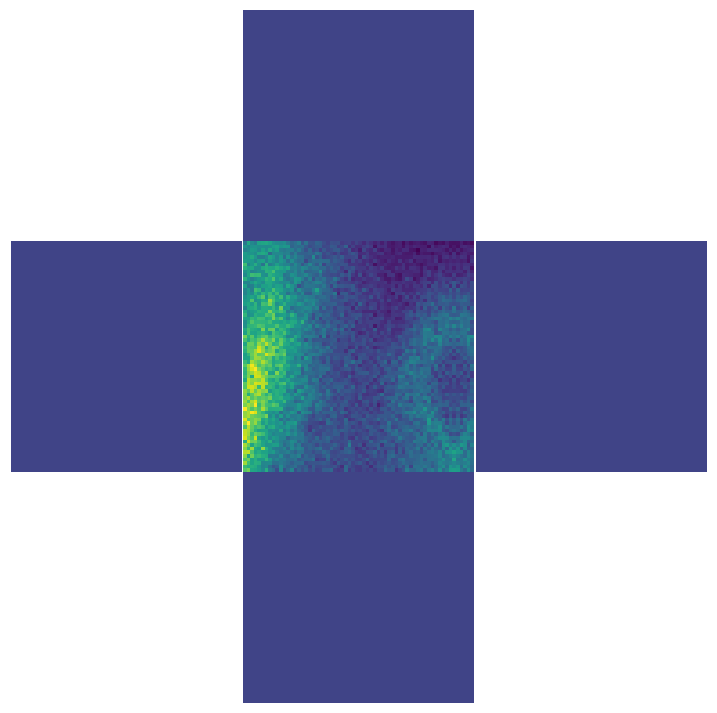

In [14]:
ch_idx = 1
ex_idx = 0

_,ax =plt.subplots(figsize=(9,9),ncols=3,nrows=3)
vmin = tr_nbrs[ex_idx,:,ch_idx].min() 
vmax = tr_nbrs[ex_idx,:,ch_idx].max()
ax[1,1].imshow(tr_nbrs[ex_idx,0,ch_idx], vmin = vmin, vmax = vmax)
ax[0,1].imshow(tr_nbrs[ex_idx,2,ch_idx], vmin = vmin, vmax = vmax)
ax[2,1].imshow(tr_nbrs[ex_idx,3,ch_idx], vmin = vmin, vmax = vmax)
ax[1,0].imshow(tr_nbrs[ex_idx,4,ch_idx], vmin = vmin, vmax = vmax)
ax[1,2].imshow(tr_nbrs[ex_idx,5,ch_idx], vmin = vmin, vmax = vmax)
clean_ax(ax)
for oneax in ax.reshape(-1,):
    oneax.spines["top"].set_visible(False)
    oneax.spines["right"].set_visible(False)
    oneax.spines["bottom"].set_visible(False)
    oneax.spines["left"].set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)


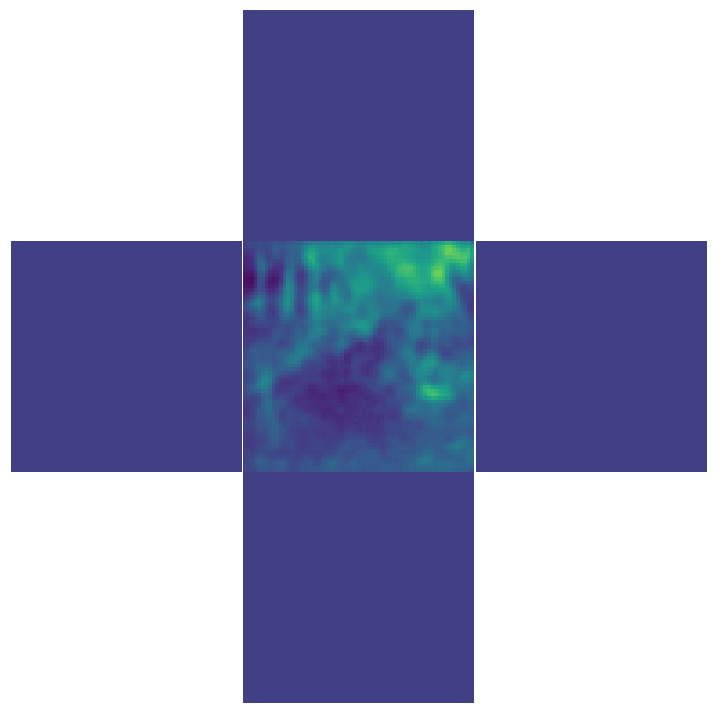

In [9]:
ch_idx = 0
ex_idx = 0

_,ax =plt.subplots(figsize=(9,9),ncols=3,nrows=3)
vmin = val_nbrs[ex_idx,:,ch_idx].min() 
vmax = val_nbrs[ex_idx,:,ch_idx].max()
ax[1,1].imshow(val_nbrs[ex_idx,1,ch_idx], vmin = vmin, vmax = vmax)
ax[0,1].imshow(val_nbrs[ex_idx,2,ch_idx], vmin = vmin, vmax = vmax)
ax[2,1].imshow(val_nbrs[ex_idx,3,ch_idx], vmin = vmin, vmax = vmax)
ax[1,0].imshow(val_nbrs[ex_idx,4,ch_idx], vmin = vmin, vmax = vmax)
ax[1,2].imshow(val_nbrs[ex_idx,5,ch_idx], vmin = vmin, vmax = vmax)
clean_ax(ax)
for oneax in ax.reshape(-1,):
    oneax.spines["top"].set_visible(False)
    oneax.spines["right"].set_visible(False)
    oneax.spines["bottom"].set_visible(False)
    oneax.spines["left"].set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)


# top,bottom,left,right

In [10]:
# _,ax = plt.subplots(figsize=(10,15), ncols=2, nrows=3)

# ax[0,0].imshow(tr[0,0])
# ax[0,1].imshow(tr_gt[0,0])

# ax[1,0].imshow(tr[3,0])
# ax[1,1].imshow(tr_gt[3,0])

# ax[2,0].imshow(val[0,0])
# ax[2,1].imshow(val_gt[0,0])